In [2]:
# !pip install numpy==1.24.3
# !pip install gensim
# !pip install num2words

import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

import gensim
import nltk
from gensim import corpora
import gensim.downloader as api
from gensim.models import KeyedVectors, LdaModel, CoherenceModel

# Sentiment analysis imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from num2words import num2words #convert numeric digits to text equivlents

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aefyb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aefyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aefyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing

In [8]:
reviews = pd.read_csv('Dataset-SA.csv')
reviews

product_name product_price Rate  \
0       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
1       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
2       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
3       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    1   
4       Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
...                                                   ...           ...  ...   
205047  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    5   
205048  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    5   
205049  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    3   
205050  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    5   
205051  cello Pack of 18 Opalware Cello Dazzle Lush Fi...          1299    4   

                 Review                                            Summary  \
0                super!  great cooler excellent air flow and for this p...   
1               awesome              best budget 2 fit cooler nice cooling   
2                  fair  the quality is good but the power of air is de...   
3       useless product                  very bad product its a only a fan   
4                  fair                                      ok ok product   
...                 ...                                                ...   
205047        must buy!                                       good product   
205048           super!                                               nice   
205049             nice                        very nice and fast delivery   
205050        just wow!                                    awesome product   
205051  value-for-money  very good but mixing bowl not included is one ...   

       Sentiment  
0       positive  
1       positive  
2       positive  
3       negative  
4        neutral  
...          ...  
205047  positive  
205048  positive  
205049  positive  
205050  positive  
205051   neutral  

[205052 rows x 6 columns]

In [9]:
reviews['product_price'] = pd.to_numeric(reviews['product_price'], errors = 'coerce')
reviews['Rate'] = pd.to_numeric(reviews['Rate'], errors = 'coerce').astype('Int64')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   product_name   205052 non-null  object 
 1   product_price  205049 non-null  float64
 2   Rate           205049 non-null  Int64  
 3   Review         180388 non-null  object 
 4   Summary        205041 non-null  object 
 5   Sentiment      205052 non-null  object 
dtypes: Int64(1), float64(1), object(4)
memory usage: 9.6+ MB


The only columns that are relvanent to our analysis are the Summary, Review, and Sentiment column so there is no need to keep the rest of the data. We also only care about the data the falls into either the positive or negative class so everything in the neutral class is removed. Duplicates are simply dropped.

In [10]:
# Drop columns not used for analysis
reviews.drop(columns = ['product_name', 'product_price', 'Rate'], inplace = True)

# Remove any data non-positive or non-negative sentiment
reviews = reviews[(reviews['Sentiment'] == 'positive') | (reviews['Sentiment'] == 'negative')].copy()
# Drop duplicates
print(f"Number of rows before dropping duplicates: {len(reviews)}")
reviews.dropna(inplace=True)
print(f"Number of rows after dropping duplicates: {len(reviews)}")

# Show data
reviews

Number of rows before dropping duplicates: 194813
Number of rows after dropping duplicates: 171572


Review                                            Summary  \
0                super!  great cooler excellent air flow and for this p...   
1               awesome              best budget 2 fit cooler nice cooling   
2                  fair  the quality is good but the power of air is de...   
3       useless product                  very bad product its a only a fan   
5               awesome  the cooler is really fantastic and provides go...   
...                 ...                                                ...   
205046   classy product                            beautiful set very nice   
205047        must buy!                                       good product   
205048           super!                                               nice   
205049             nice                        very nice and fast delivery   
205050        just wow!                                    awesome product   

       Sentiment  
0       positive  
1       positive  
2       positive  
3       negative  
5       positive  
...          ...  
205046  positive  
205047  positive  
205048  positive  
205049  positive  
205050  positive  

[171572 rows x 3 columns]

### Text Cleaning

In [11]:
# Load stop words from NLTK to remove from reviews and summaries
stop_words = set(stopwords.words('english'))
# Initialize Word Lemmanizer
lemmatizer = WordNetLemmatizer()

def text_cleaning(text):
  """
  Input: single string of text data.
  Output: single cleaned text as string data.
  This function takes raw text as string data and returns a cleaned text as string data.
  Cleaning invovles:
  - making everything lowercase
  - removing anything that is not a letter or number
  - adding space between letter and number that are combined into one word (ex. covid19 => covid 19)
  - convert digits into text equivalent (ex. 1 => one)
  - remove stop words
  - remove double spaces
  """
  text = text.lower()
  text = re.sub(r"'", "", text) #turn conjugations into single words
  text = re.sub(r"[^a-z0-9 ]", " ", text) # This line removes anything that is not a number or letter
  text = re.sub(r"([a-z])([0-9])", r"\1 \2", text)  # Add space between letter and number
  text = re.sub(r"([0-9])([a-z])", r"\1 \2", text)  # Add space between number and letter
  text = re.sub(r'\d+', lambda match: num2words(int(match.group())), text) #convert all digits into text equivalent  (ex. 1 => one)
  text = ' '.join([word for word in text.split() if word not in stop_words])
  text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
  return text

def lemmatize_text(word):
  # NLTK's lemmatizer expects a pos category. We try all categories and see which one changes
  lemma = lemmatizer.lemmatize(word, pos='n')
  if lemma == word:
    lemma = lemmatizer.lemmatize(word, pos='v')
    if lemma == word:
      lemma = lemmatizer.lemmatize(word, pos='a')
      if lemma == word:
        lemma = lemmatizer.lemmatize(word, pos='r')
  return lemma

def preprocess(text):
  """
  Input: single string of text data.
  Output: single cleaned and lemmanized text as string data.
  """
  cleaned_text = text_cleaning(text)
  # Tokenize the text
  tokens = word_tokenize(cleaned_text)
  # Lemmatize words
  tokens = [lemmatize_text(word) for word in tokens]
  # Combine tokens back into a continous string - added
  tokens = ' '.join(tokens)
  return tokens


def map_sentiment(label):
  """
  This function takes a single label of positive or negative as a string and returns a binary value of 1 or 0.
  positive => 1
  negative => 0
  If the label is not positive or negative, the label will returned with no changes.
  """
  if 'positive' == label: # Error handling for running code block multiple times
    label = 1
  elif 'negative' == label:
    label = 0
  else:
    pass

  return label

# Combine the review text and summary into a single columns
reviews.loc[:, 'review_text'] = reviews['Review'] + ' ' + reviews['Summary']

# Clean and lemmanize text
reviews['processed_review'] = reviews['review_text'].progress_apply(preprocess)
# Map sentiments to a numeric binary
reviews['Sentiment'] = reviews['Sentiment'].progress_apply(map_sentiment)

# Show data
reviews.head()

100%|█████████████████████████████████████████████████████████████████████| 171572/171572 [00:00<00:00, 1927734.26it/s]


Review                                            Summary  \
0           super!  great cooler excellent air flow and for this p...   
1          awesome              best budget 2 fit cooler nice cooling   
2             fair  the quality is good but the power of air is de...   
3  useless product                  very bad product its a only a fan   
5          awesome  the cooler is really fantastic and provides go...   

   Sentiment                                        review_text  \
0          1  super! great cooler excellent air flow and for...   
1          1      awesome best budget 2 fit cooler nice cooling   
2          1  fair the quality is good but the power of air ...   
3          0  useless product very bad product its a only a fan   
5          1  awesome the cooler is really fantastic and pro...   

                                    processed_review  
0  super great cool excellent air flow price amaz...  
1         awesome best budget two fit cool nice cool  
2                 fair quality good power air decent  
3                    useless product bad product fan  
5  awesome cool really fantastic provide good air...

In [12]:
# Distribution of the sentiment
reviews['Sentiment'].value_counts()/len(reviews)

Sentiment
1    0.85778
0    0.14222
Name: count, dtype: float64

create train-validation-test split

In [13]:
# First, split off the test set
train_val, test = train_test_split(reviews, test_size=0.2, random_state=42)

# Then split the remaining into train and validation
train, val = train_test_split(train_val, test_size=0.25, random_state=42)

# Seperate data and label
X_train = train['processed_review']
y_train = train['Sentiment']
X_val = val['processed_review']
y_val = val['Sentiment']
X_test = test['processed_review']
y_test = test['Sentiment']

In [14]:
import pickle as pkl
pkl.dump(X_train,open('X_train','wb'))
pkl.dump(y_train,open('y_train','wb'))
pkl.dump(X_val,open('X_val','wb'))
pkl.dump(y_val,open('y_val','wb'))
pkl.dump(X_test,open('X_test','wb'))
pkl.dump(y_test,open('y_test','wb'))

## Feature Engineering (Vectorization)

### Count Vectorizer

In [15]:
# Initalize count vectorizer
count_vectorizer = CountVectorizer(max_features=5000)
# Fit vectorizer on train data
X_train_count_vec = count_vectorizer.fit_transform(X_train)
# Used fitted vectorizer to transform test and val data
X_val_count_vec = count_vectorizer.transform(X_val)
X_test_count_vec = count_vectorizer.transform(X_test)

### TfidfVectorizer

In [16]:
# Initalize count vectorizer
tfidif_vectorizer = TfidfVectorizer(max_features=5000)
# Fit vectorizer on train data
X_train_tfidf_vec = tfidif_vectorizer.fit_transform(X_train)
# Used fitted vectorizer to transform test and val data
X_val_tfidf_vec = tfidif_vectorizer.transform(X_val)
X_test_tfidf_vec = tfidif_vectorizer.transform(X_test)

### Glove Embeddings

In [17]:
# Load glove embeddings
# Only take the time to install glove if it was not been installed yet
try:
  print(glove_model)
except:
  glove_model = api.load("glove-wiki-gigaword-100")

# Create function for assigning embeddings
def glove_embeddings(review,glove_model=glove_model):
  """
  Input: a single review in the form of one continuous string.
  Output: Mean of all token embeddings in review.

  Steps:
  1.) Tokenize review by words.
  2.) Assign embedding to each token (word) from glove model.
  3.) Return mean of all embeddings.

  """
  tokens = review.split()
  embeddings = [glove_model[token] for token in tokens if token in glove_model]
  # Handle the case where no embeddings are found for the review
  if not embeddings:
    # Return a zero vector of the correct size
    return np.zeros(glove_model.vector_size)
  else:
    # Return mean of embeddings, reshaped to a 1D array
    return np.mean(embeddings, axis=0).reshape(1, -1) # Reshape ensures consistent dimensions

In [18]:
# Embed reviews
# Use pandas apply for parrallel processing
# Stack the embeddings into a 2D NumPy array
X_train_glove = np.vstack(X_train.progress_apply(glove_embeddings).to_numpy()) # Stack embeddings into a 2D array
X_val_glove = np.vstack(X_val.progress_apply(glove_embeddings).to_numpy()) # Stack embeddings into a 2D array
X_test_glove = np.vstack(X_test.progress_apply(glove_embeddings).to_numpy()) # Stack embeddings into a 2D array

100%|█████████████████████████████████████████████████████████████████████████| 34315/34315 [00:00<00:00, 63078.92it/s]


## Keyword Extraction

Changed the vectorizer to only transform as it was already fit during the sentiment analysis step and we should use the same vectorizer for all steps. We should also keep in mind that positive words occur far more frequently as the positive class occurs far more frequently.

Edit 2:
Seperated positive and negative reviews for keyword analysis due to the embalance of class. Also changed to use the same vectorizer as classification as lemmanization is no preformed during text cleaning.

In [19]:
# Assuming tfidf and glove have same or near same vocabulary as they originate from the same data
# Seperate positive and negative reviews to compare key words
positive_reviews = reviews[reviews['Sentiment'] == 1]
negative_reviews = reviews[reviews['Sentiment'] == 0]

# Extracting vocabulary from count vectorizer
count_keywords = count_vectorizer.get_feature_names_out()

# Create a vectorized version of the entire dataset for new dataframe
count_df = pd.DataFrame(data = count_vectorizer.transform(reviews['processed_review']).toarray(), columns=count_keywords) #count vectorizer

# Do the same for a positive and negative version
# Positive key words
positive_count_df = pd.DataFrame(data = count_vectorizer.transform(positive_reviews['processed_review']).toarray(), columns=count_keywords)

# Negative key words
negative_count_df = pd.DataFrame(data = count_vectorizer.transform(negative_reviews['processed_review']).toarray(), columns=count_keywords)

# Count each words occurances in positive and negative
positive_count_scores = positive_count_df.sum().sort_values(ascending=False) # Getting total count
negative_count_scores = negative_count_df.sum().sort_values(ascending=False) # Getting total count

print("Top Positive Sentiment CountVectorizer keywords:")
print(positive_count_scores.head(50)) # top 50 common positive words when evaluating products
print("\nTop Negative Sentiment CountVectorizer keywords:")
print(negative_count_scores.head(50)) # top 50 common negative words when evaluating products

# Should keep in mind that positive words are much more common because our positive class is much more common !

Top Positive Sentiment CountVectorizer keywords:
good         84674
product      74746
nice         42226
quality      18845
awesome      17995
best         15658
purchase     12649
super        12434
money        12398
worth        11818
buy          11382
excellent    10866
terrific     10792
great         9615
one           9508
wonderful     9480
price         7689
value         7614
flipkart      7450
perfect       7300
must          7190
really        7100
recommend     6976
specify       6695
thank         6687
use           6638
every         6239
wow           6134
market        5959
highly        5890
simply        5802
fabulous      5733
penny         5685
mind          5633
brilliant     5615
classy        5586
blow          5562
work          5453
love          4726
like          4652
sound         4475
also          4203
happy         4077
go            4058
two           3908
hundred       3884
delivery      3834
pretty        3748
get           3625
choice        3618
d

In [20]:
def get_top_keywords_per_review(row, feature_names, top_n=5):
    row_array = row.to_numpy()
    top_indices = row_array.argsort()[-top_n:][::-1]
    return [feature_names[i] for i in top_indices if row_array[i] > 0]


reviews['top_keywords'] = count_df.progress_apply(lambda row: get_top_keywords_per_review(row, count_keywords), axis=1)
reviews

100%|███████████████████████████████████████████████████████████████████████| 171572/171572 [00:05<00:00, 30028.38it/s]


Review                                            Summary  \
0                super!  great cooler excellent air flow and for this p...   
1               awesome              best budget 2 fit cooler nice cooling   
2                  fair  the quality is good but the power of air is de...   
3       useless product                  very bad product its a only a fan   
5               awesome  the cooler is really fantastic and provides go...   
...                 ...                                                ...   
205046   classy product                            beautiful set very nice   
205047        must buy!                                       good product   
205048           super!                                               nice   
205049             nice                        very nice and fast delivery   
205050        just wow!                                    awesome product   

        Sentiment                                        review_text  \
0               1  super! great cooler excellent air flow and for...   
1               1      awesome best budget 2 fit cooler nice cooling   
2               1  fair the quality is good but the power of air ...   
3               0  useless product very bad product its a only a fan   
5               1  awesome the cooler is really fantastic and pro...   
...           ...                                                ...   
205046          1             classy product beautiful set very nice   
205047          1                             must buy! good product   
205048          1                                        super! nice   
205049          1                   nice very nice and fast delivery   
205050          1                          just wow! awesome product   

                                         processed_review  \
0       super great cool excellent air flow price amaz...   
1              awesome best budget two fit cool nice cool   
2                      fair quality good power air decent   
3                         useless product bad product fan   
5       awesome cool really fantastic provide good air...   
...                                                   ...   
205046                  classy product beautiful set nice   
205047                              must buy good product   
205048                                         super nice   
205049                            nice nice fast delivery   
205050                                wow awesome product   

                                  top_keywords  
0       [amaze, price, great, cool, excellent]  
1               [cool, fit, two, nice, budget]  
2          [fair, decent, quality, power, air]  
3                 [product, useless, fan, bad]  
5           [recommend, highly, good, product]  
...                                        ...  
205046                                     NaN  
205047                                     NaN  
205048                                     NaN  
205049                                     NaN  
205050                                     NaN  

[171572 rows x 6 columns]

### Created Seperate Positive and Negative Word Clouds due to class imbalance

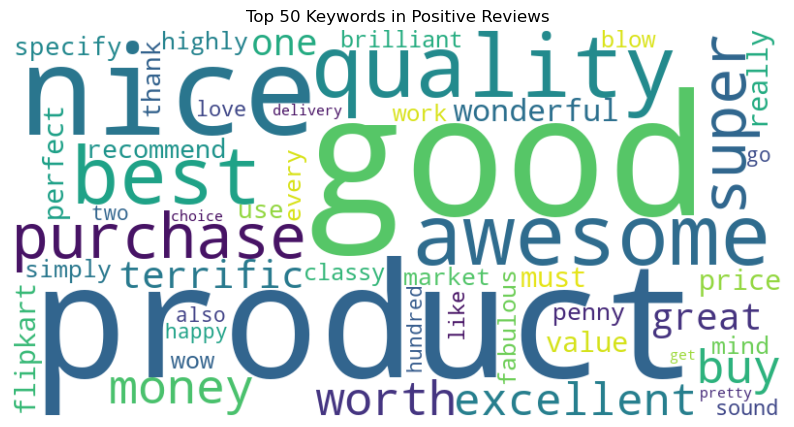

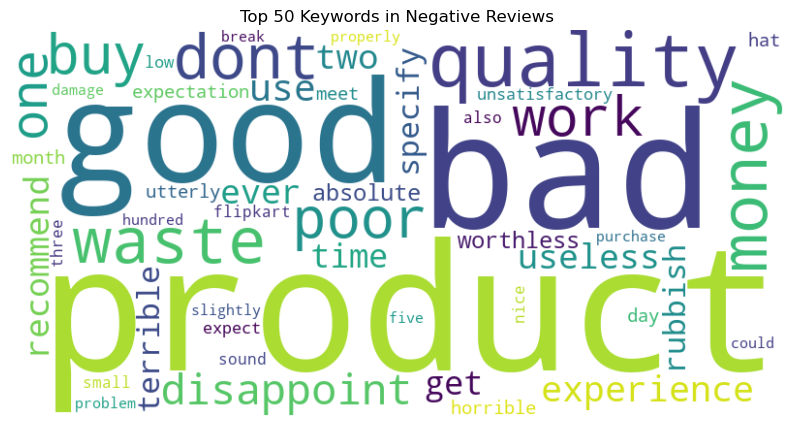

In [21]:
# Get the 50 most common keywords
top_positive_keywords= (positive_count_scores.head(50)).to_dict()
top_negative_keywords= (negative_count_scores.head(50)).to_dict()

# Display the positive word cloud
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_positive_keywords)
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Keywords in Positive Reviews')
plt.show()

# Spacer
print('\n')

# Display the negative word cloud
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_negative_keywords)
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Keywords in Negative Reviews')
plt.show()

## Topic Modeling & Reporting

#### LDA

In [22]:
tokens = []
for review in reviews['processed_review'].tolist():
  tokens.extend(review.split())
unique_tokens = list(set(tokens))

In [23]:
# Changed to convert processed_summary into a list of a list of tokens
processed_data = [review.split() for review in reviews['processed_review'].tolist()]

# Changed to convert processed_summary into a list of a list of tokens
dictionary = corpora.Dictionary(processed_data)
print("Vocabulary = ", dictionary)

# Convert unique words into word_ids. Then, construct a word_id->word_frequency dictionary
corpus = [dictionary.doc2bow(text) for text in processed_data]

# Create processed data for just negative and just positive
positive_processed_data = [review.split() for review in reviews.loc[reviews['Sentiment']==1,"processed_review"].tolist()]
negative_processed_data = [review.split() for review in reviews.loc[reviews['Sentiment']==0,"processed_review"].tolist()]

Vocabulary =  Dictionary<35742 unique tokens: ['air', 'amaze', 'cool', 'excellent', 'flow']...>


### Find an optimal number of topics by comaring the coherence score of multiple models

In [24]:
def compute_coherence_values(dictionary, corpus, texts, step, limit, start=2):
    """
    Taken from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc=f'Testing Topic Counts'):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# Gets results for different topic amounts
# Can take a long time to run.
# Taken from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
positive_model_list, positive_coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=positive_processed_data,step=3, limit=80)
negative_model_list, negative_coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=negative_processed_data,step=3, limit=80)

Testing Topic Counts: 100%|████████████████████████████████████████████████████████████| 26/26 [08:26<00:00, 19.47s/it]


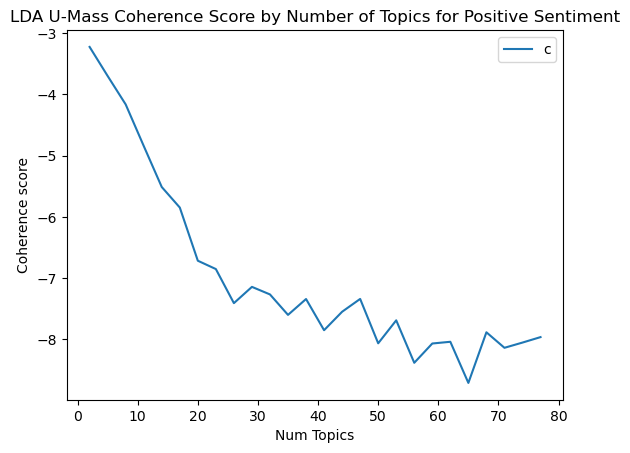

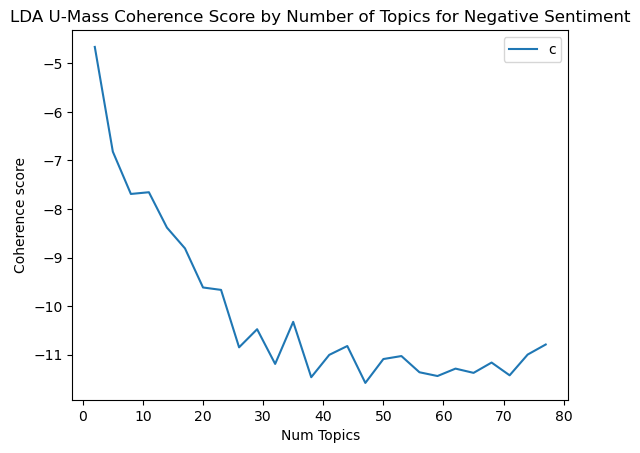

In [26]:
# Show graph
limit=80; start=2; step=3;
intervals = range(start, limit, step)
# Positive
plt.plot(intervals, positive_coherence_values)
plt.title('LDA U-Mass Coherence Score by Number of Topics for Positive Sentiment')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Negative
plt.plot(intervals, negative_coherence_values)
plt.title('LDA U-Mass Coherence Score by Number of Topics for Negative Sentiment')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
idx=0
print('Positive')
for m, cv in zip(intervals, positive_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), f'index:{idx}')
    idx+=1
print('\nNegative')
idx=0
for m, cv in zip(intervals, negative_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), f'index:{idx}')
    idx+=1

Positive
Num Topics = 2  has Coherence Value of -3.2247 index:0
Num Topics = 5  has Coherence Value of -3.699 index:1
Num Topics = 8  has Coherence Value of -4.1632 index:2
Num Topics = 11  has Coherence Value of -4.8409 index:3
Num Topics = 14  has Coherence Value of -5.5113 index:4
Num Topics = 17  has Coherence Value of -5.8462 index:5
Num Topics = 20  has Coherence Value of -6.7145 index:6
Num Topics = 23  has Coherence Value of -6.8505 index:7
Num Topics = 26  has Coherence Value of -7.4068 index:8
Num Topics = 29  has Coherence Value of -7.1412 index:9
Num Topics = 32  has Coherence Value of -7.2646 index:10
Num Topics = 35  has Coherence Value of -7.5984 index:11
Num Topics = 38  has Coherence Value of -7.3395 index:12
Num Topics = 41  has Coherence Value of -7.8487 index:13
Num Topics = 44  has Coherence Value of -7.5473 index:14
Num Topics = 47  has Coherence Value of -7.3379 index:15
Num Topics = 50  has Coherence Value of -8.0624 index:16
Num Topics = 53  has Coherence Value

### Positive

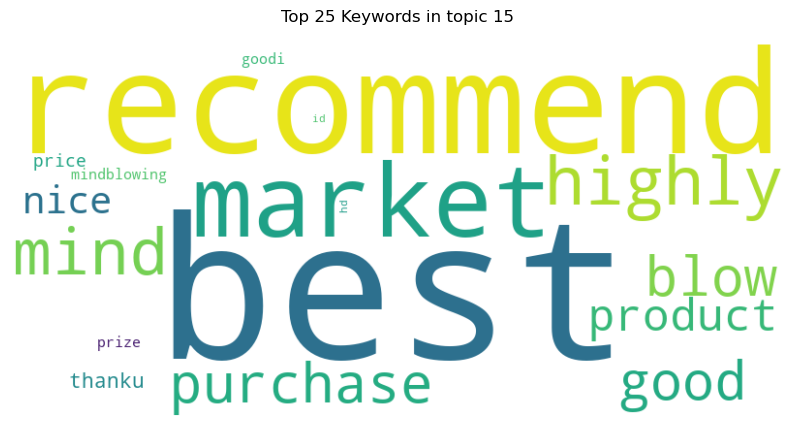

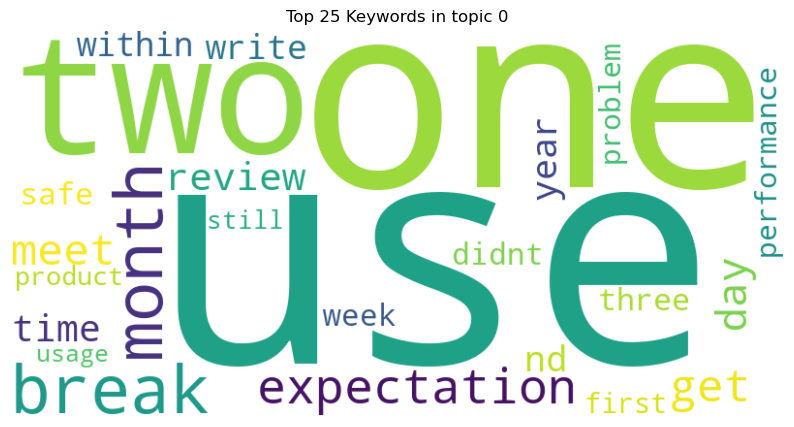

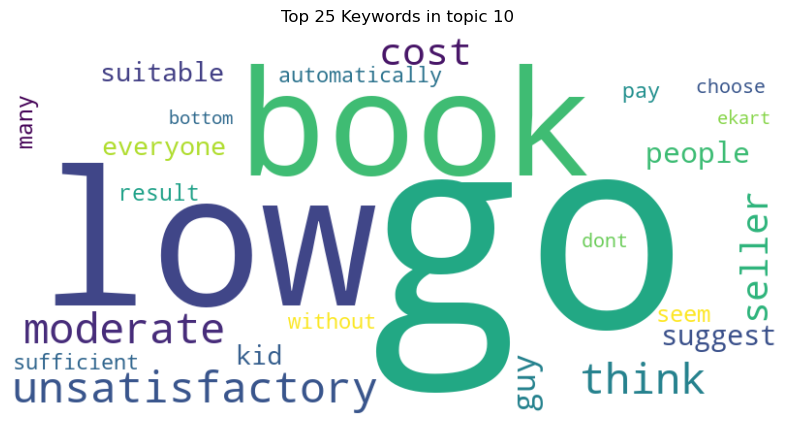

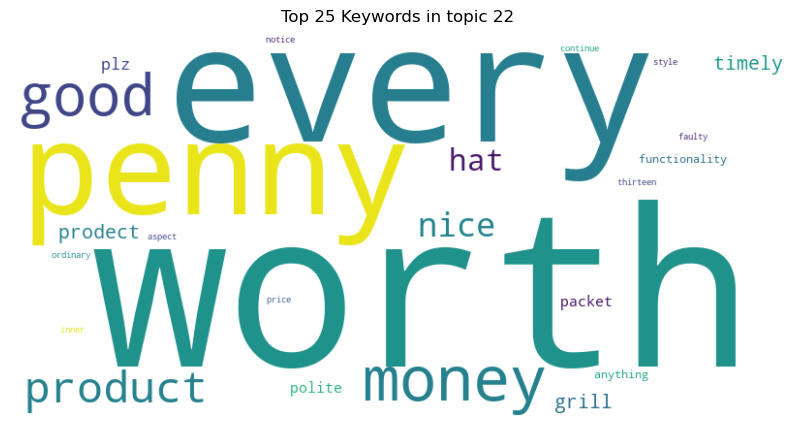

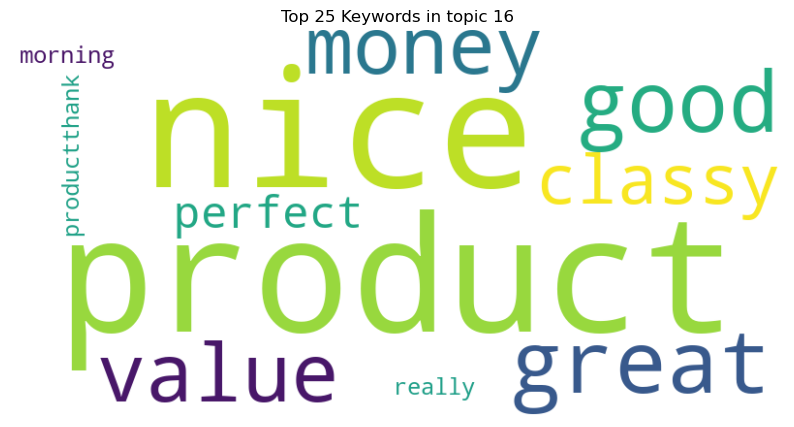

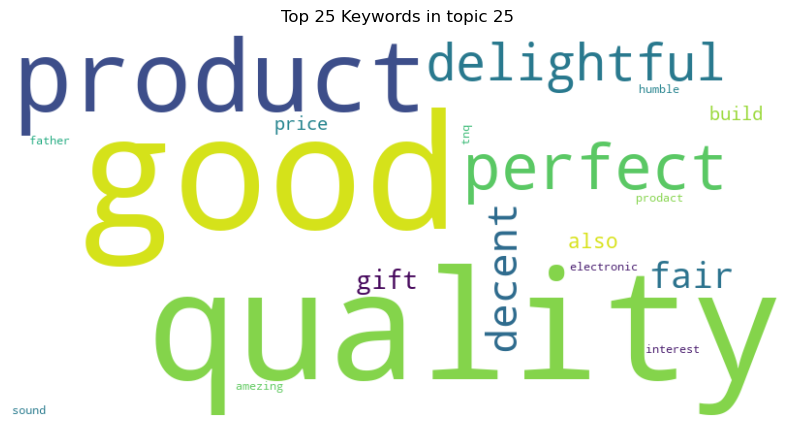

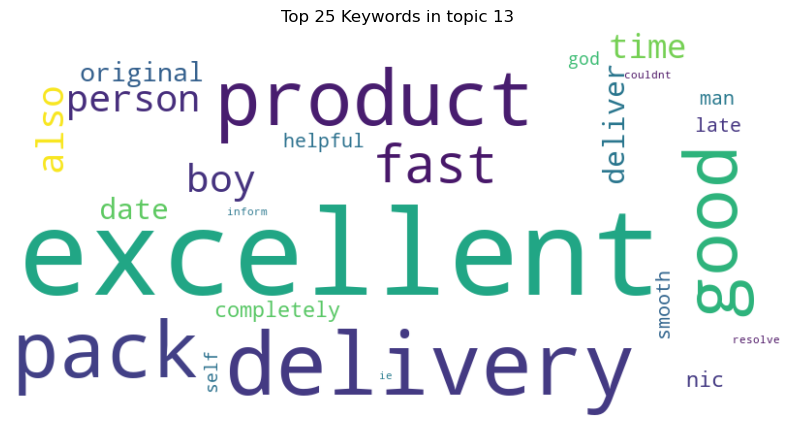

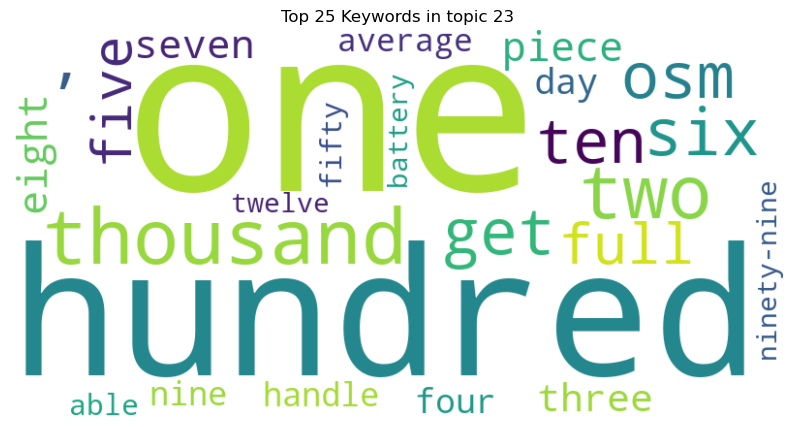

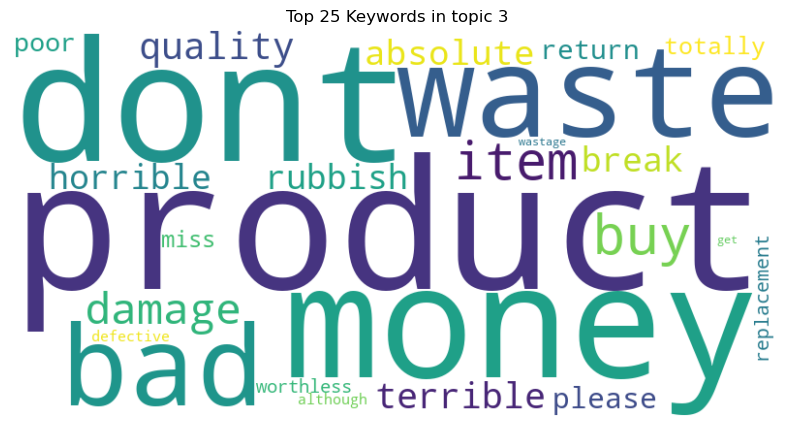

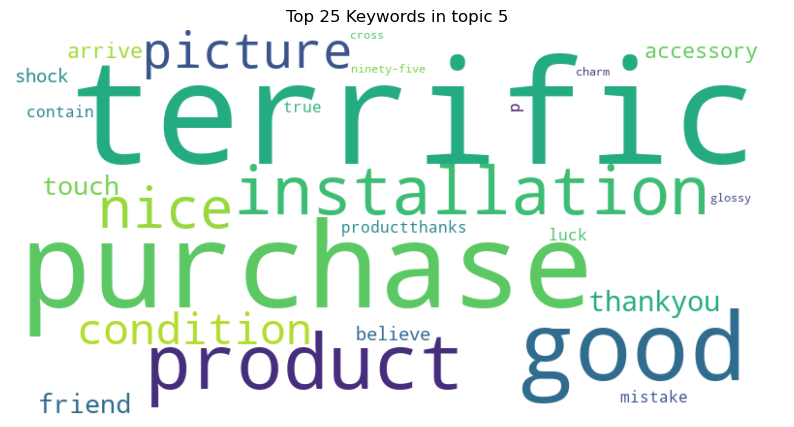

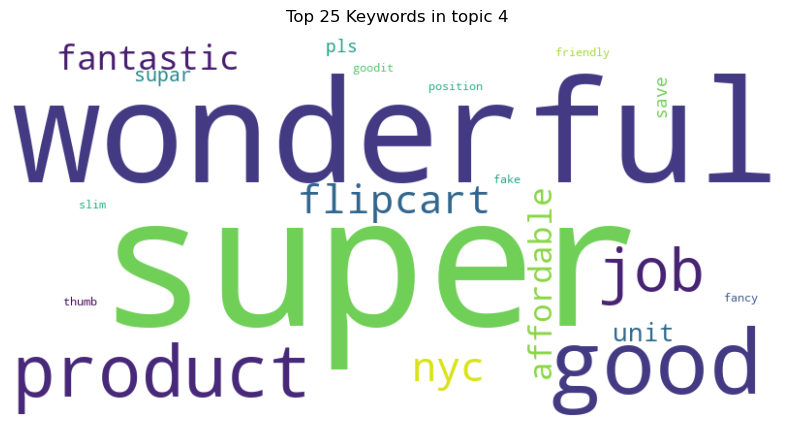

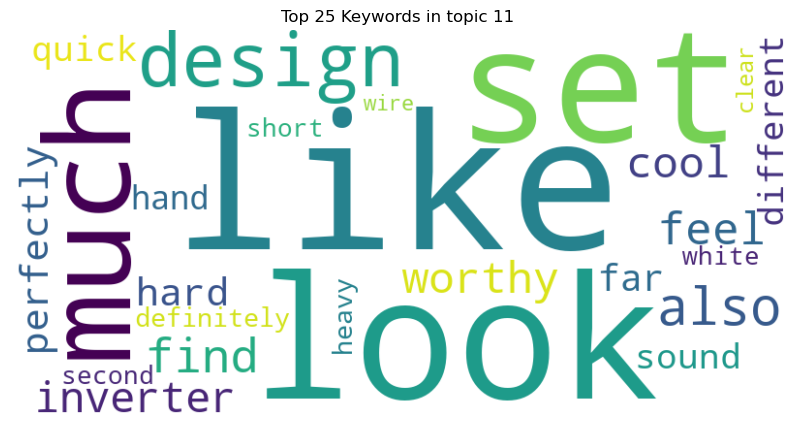

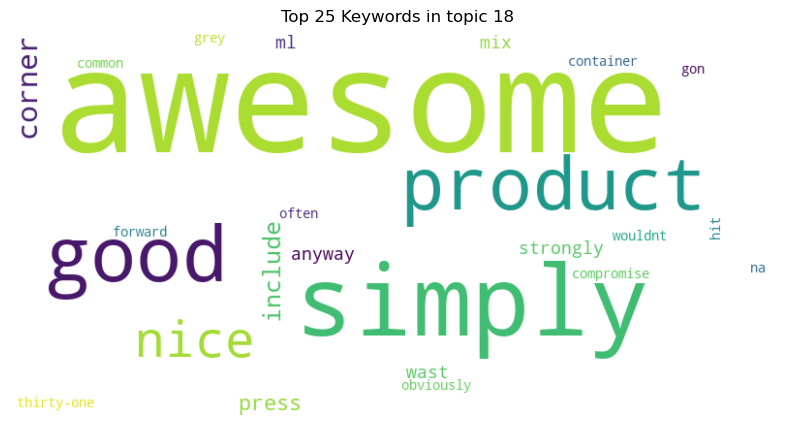

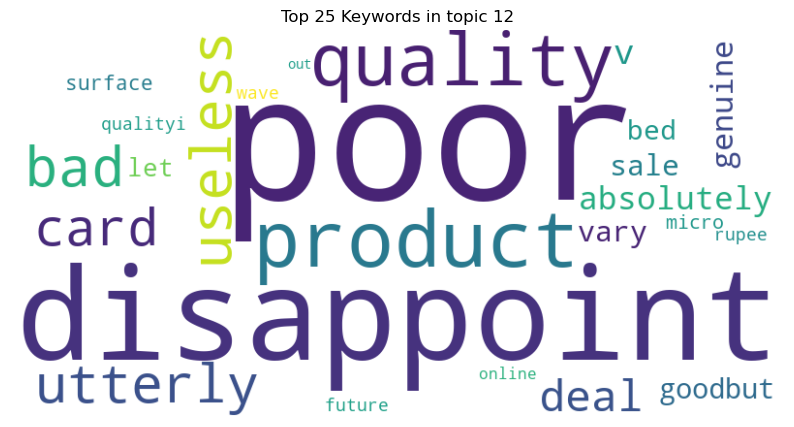

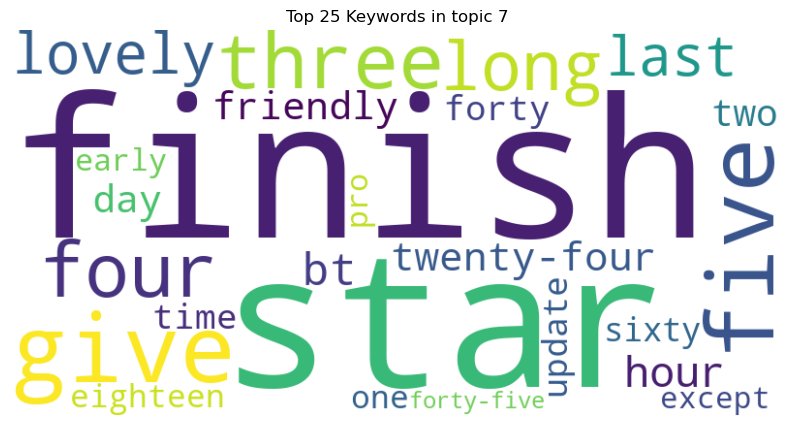

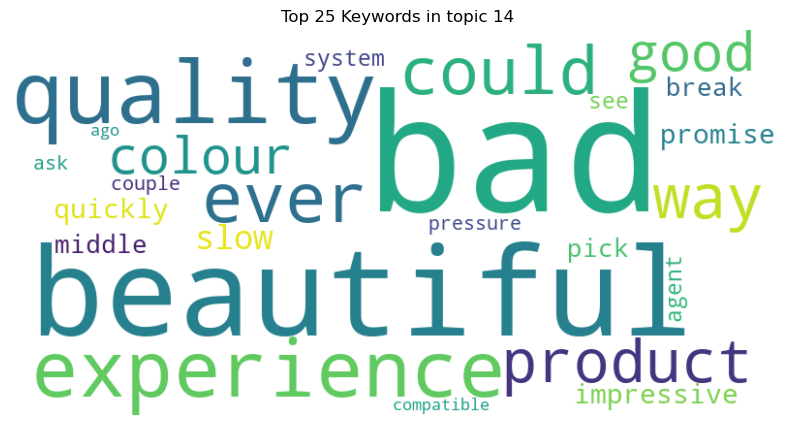

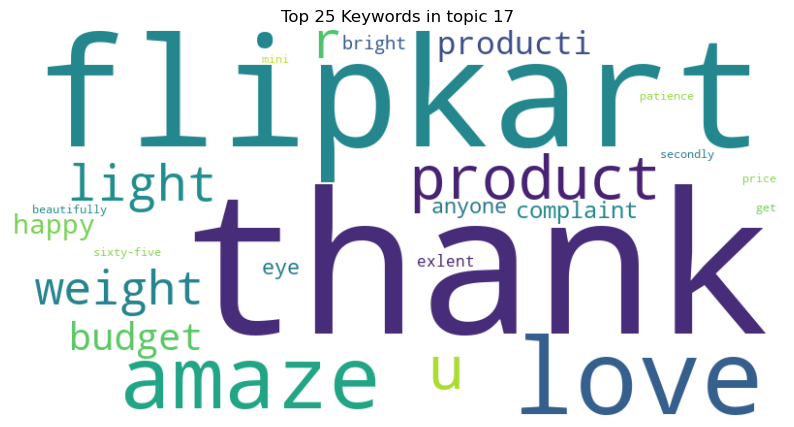

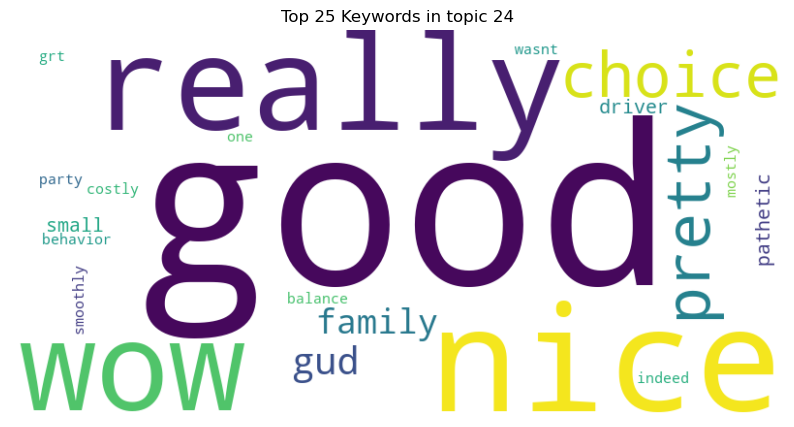

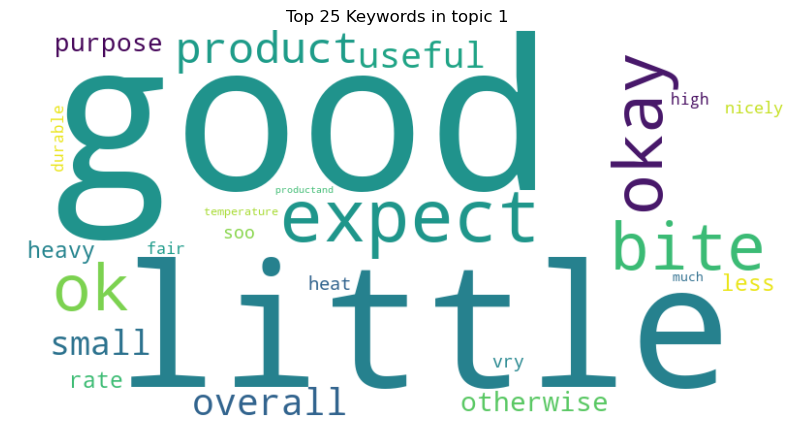

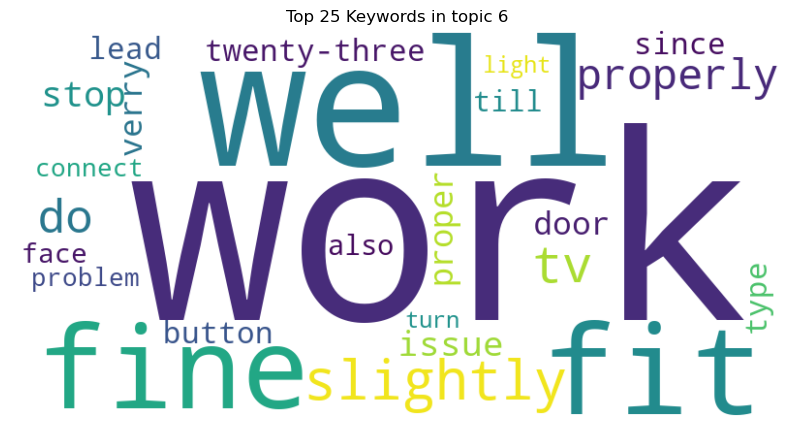

In [28]:
# Select the model and print the topics
optimal_model = positive_model_list[8] #26 topics
# Select model
model_topics = optimal_model.show_topics(formatted=True)
# Free space of unsued models
del positive_model_list
del positive_coherence_values

# Set number of words to be taken from each topic
num_top_words = 25

# Create dictionary to store reformatted word importance of each topic
topic_importance = {}

# Create a word cloud for each topic in the optimal model
for topic in optimal_model.print_topics(num_words=num_top_words):
  # Get the topic number
  topic_num = topic[0]
  # Get list of each word and its importance score
  topic_words = topic[1].split('+')
  # Start dictionary for this topic number
  topic_importance[topic_num] = {}
  for word in topic_words:
    word_importance = {word.split('*')[1].replace('"','').strip():float(word.split('*')[0])}
    topic_importance[topic_num].update(word_importance)

  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_importance[topic_num])
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Top {num_top_words} Keywords in topic {topic_num}')
  plt.show()
  print('\n') # Spacer

#### Negative

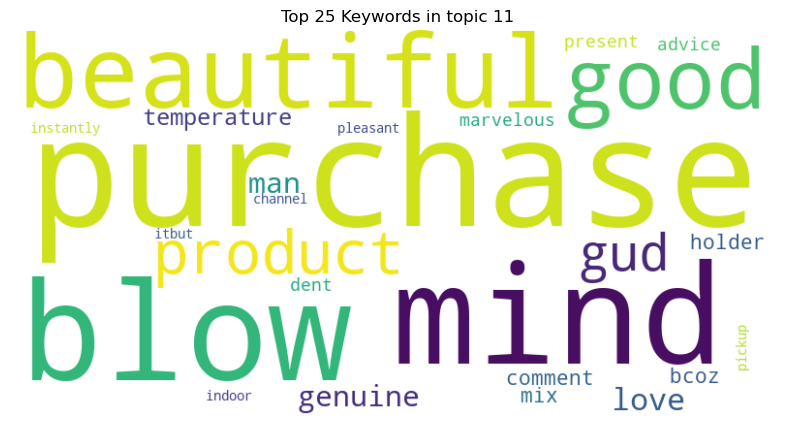

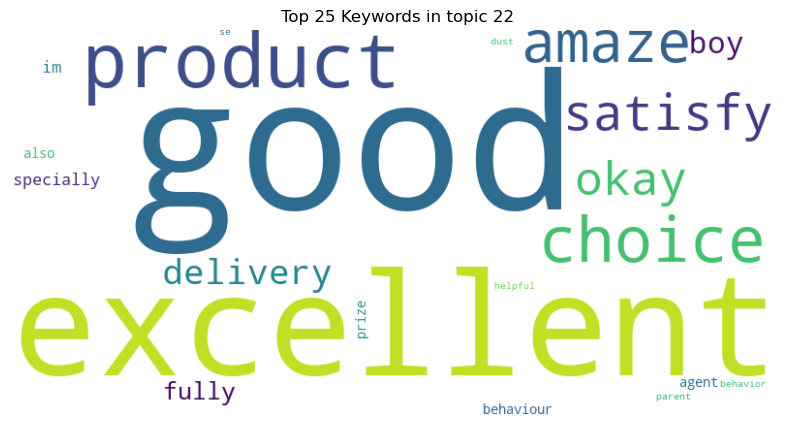

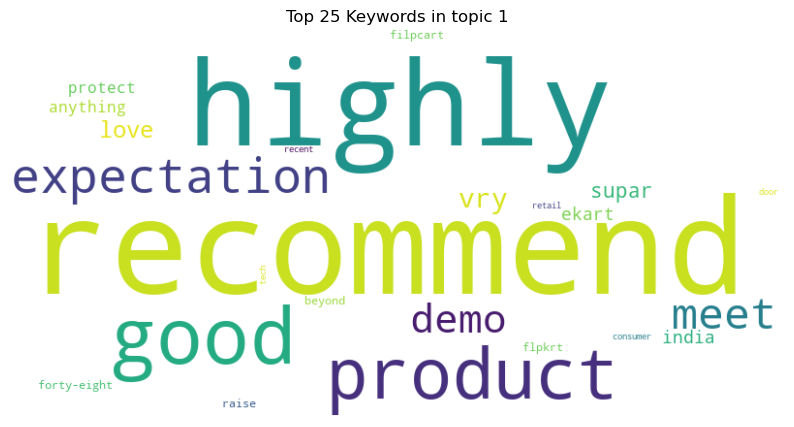

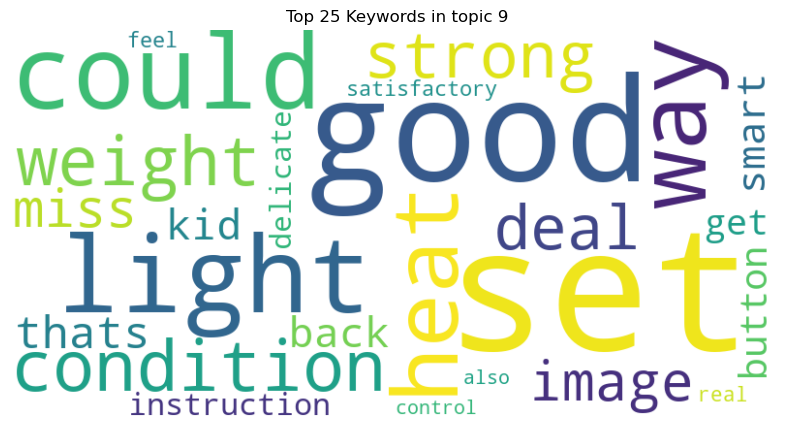

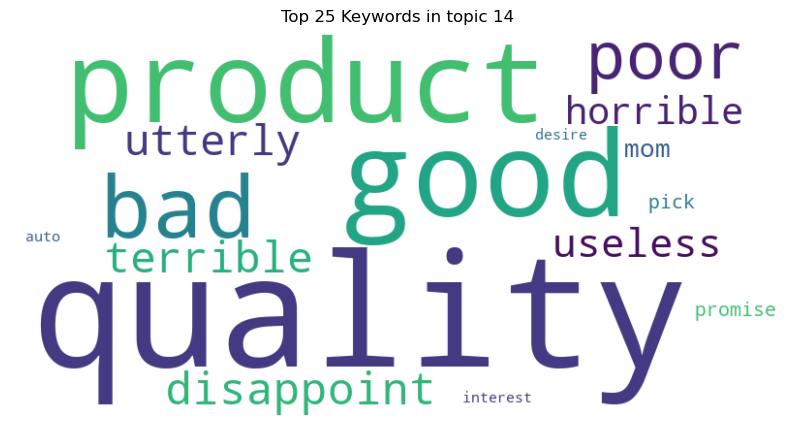

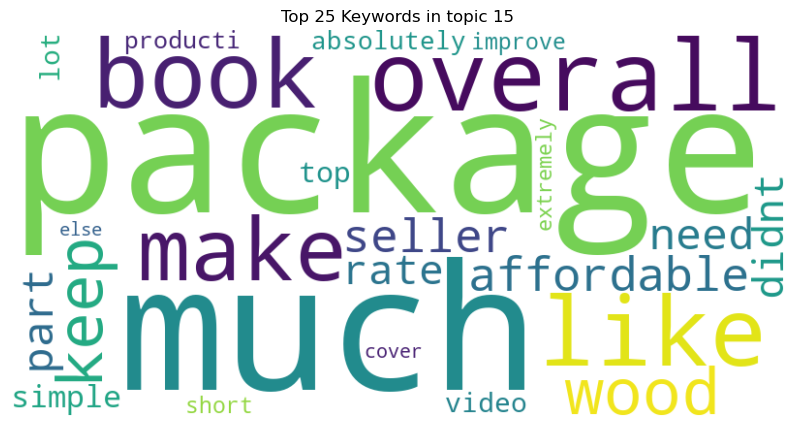

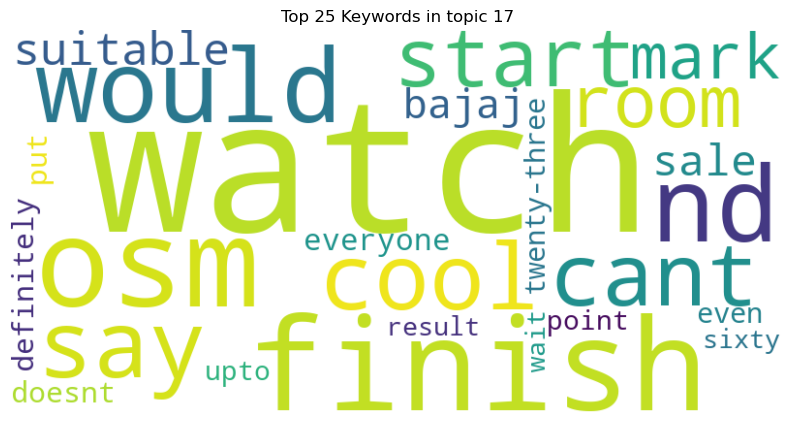

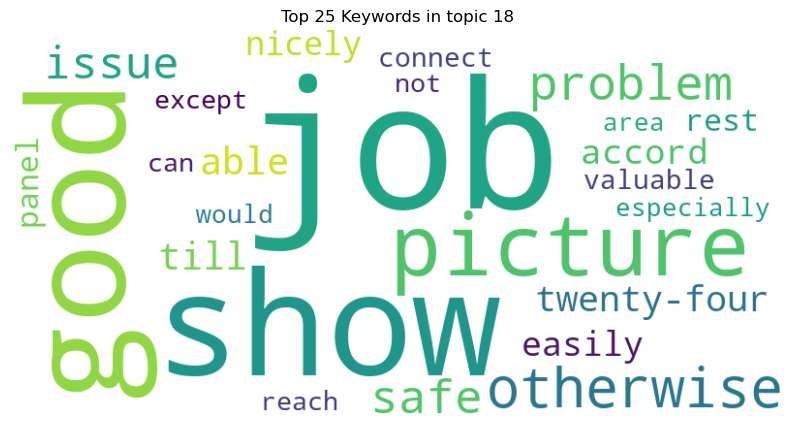

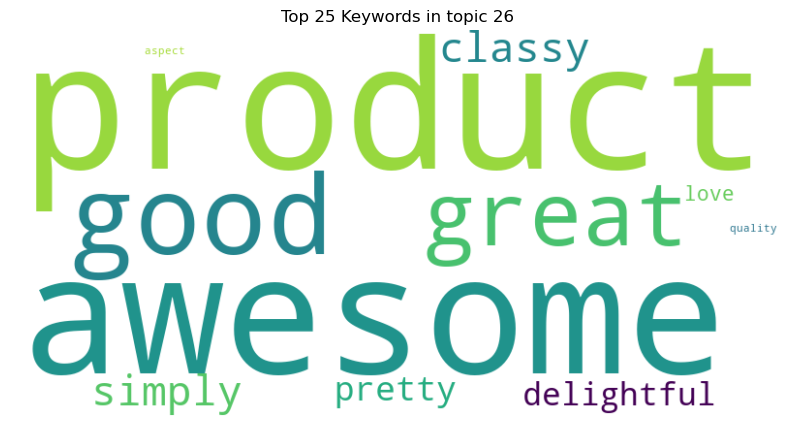

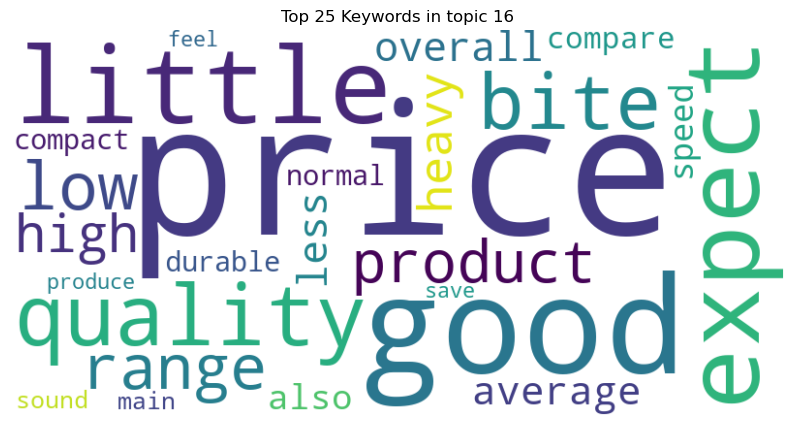

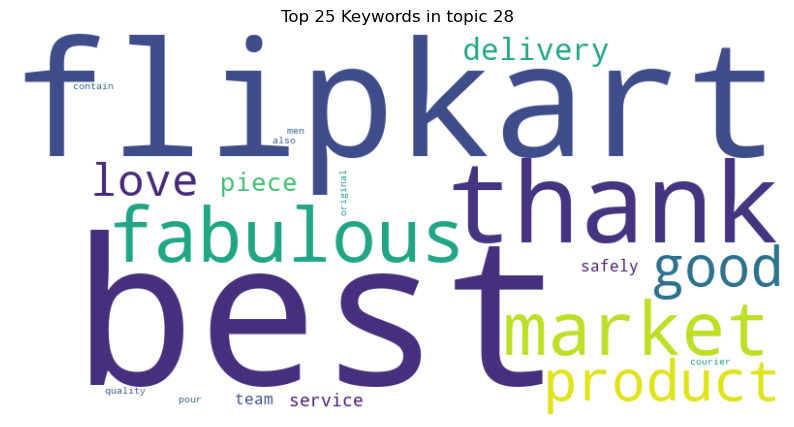

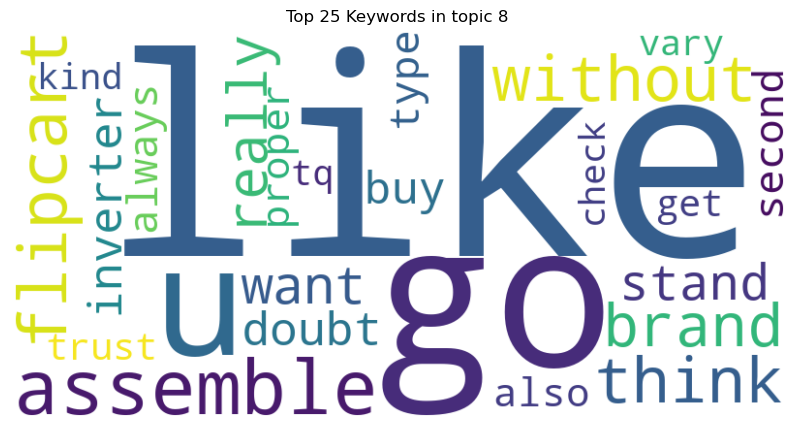

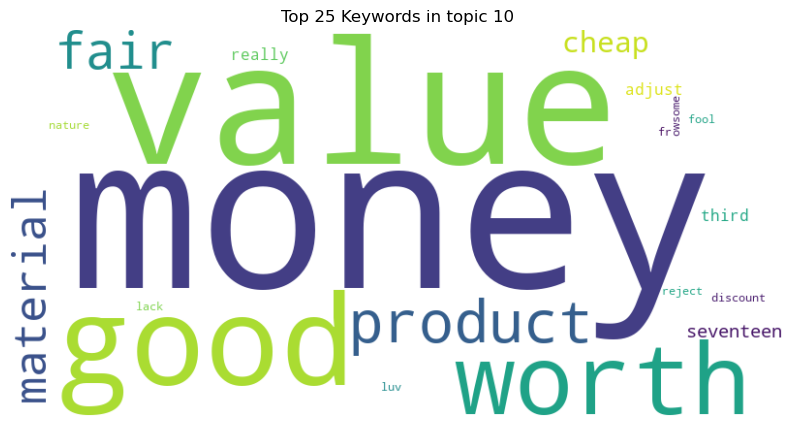

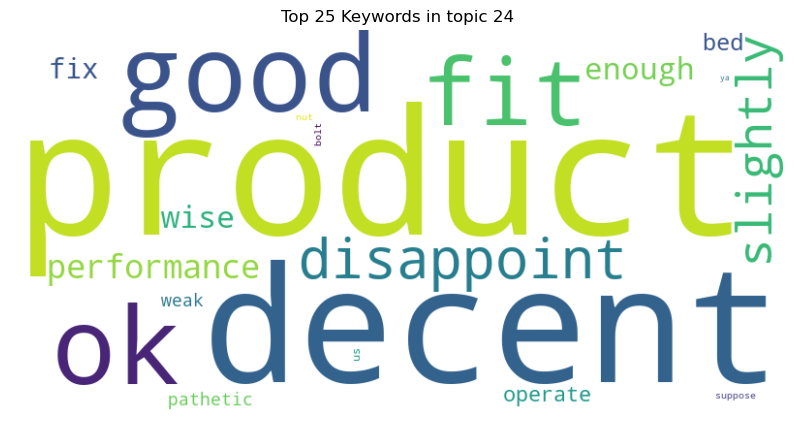

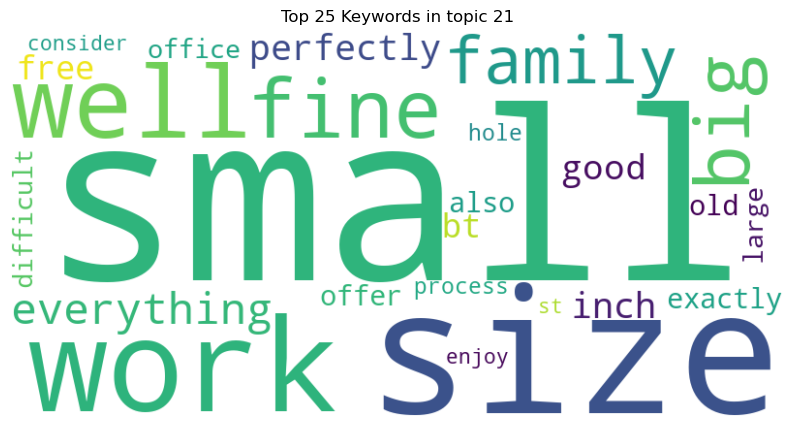

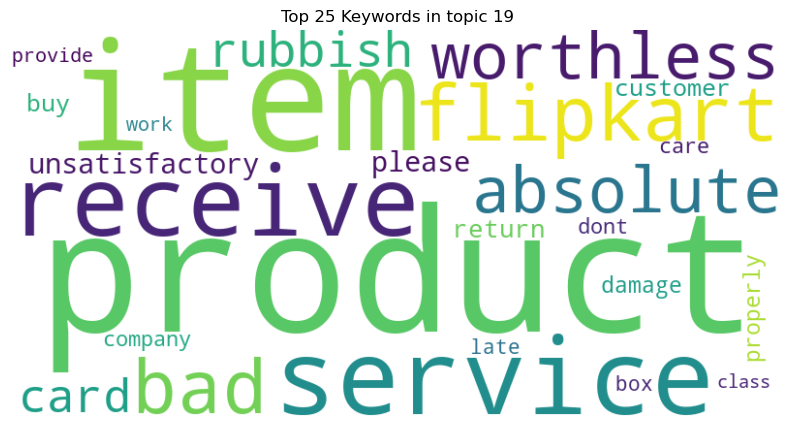

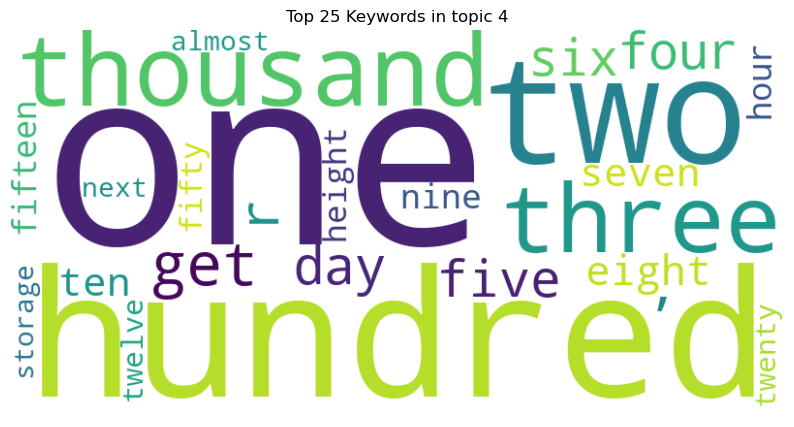

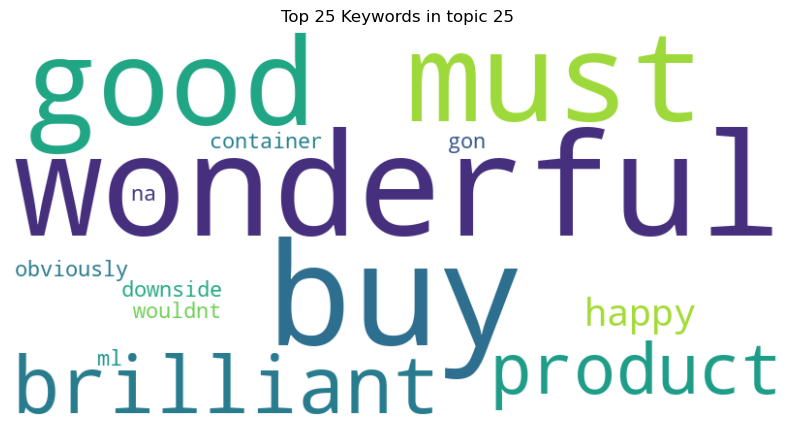

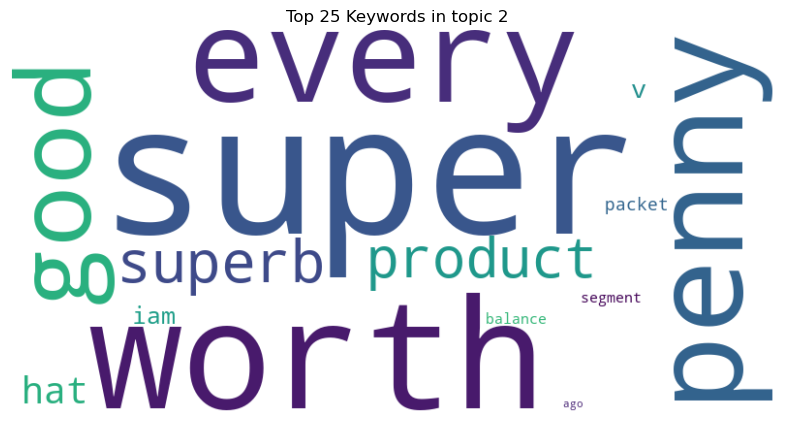

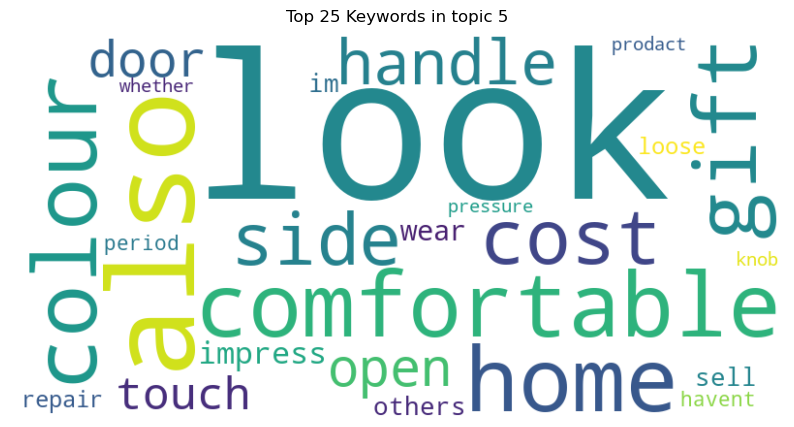

In [29]:
# Select the model and print the topics
optimal_model = negative_model_list[9] #29 topics

# Select model
model_topics = optimal_model.show_topics(formatted=True)

# Free space of unsued models
del negative_model_list
del negative_coherence_values

# Set number of words to be taken from each topic
num_top_words = 25

# Create dictionary to store reformatted word importance of each topic
topic_importance = {}

# Create a word cloud for each topic in the optimal model
for topic in optimal_model.print_topics(num_words=num_top_words):
    
  # Get the topic number
  topic_num = topic[0]
  # Get list of each word and its importance score
  topic_words = topic[1].split('+')
  # Start dictionary for this topic number
  topic_importance[topic_num] = {}
  for word in topic_words:
    word_importance = {word.split('*')[1].replace('"','').strip():float(word.split('*')[0])}
    topic_importance[topic_num].update(word_importance)

  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_importance[topic_num])
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Top {num_top_words} Keywords in topic {topic_num}')
  plt.show()
  print('\n') # Spacer

### Classification Model

In [30]:
def train_and_evaluate_classifier(model_type,classifier, X_train, y_actual, X_test, y_test_actual):
  classifier.fit(X_train, y_actual)
  y_pred = classifier.predict(X_test)
    
  # Return results of model through classification report
  results = classification_report(y_test_actual, y_pred)
  print(model_type,'\n',results,'\n')
  return results

### count vectorizer model

In [31]:
# Count vectorizer
model_type = 'count'
# Logisitc
print('Logistic Regression')
classifier = LogisticRegression(max_iter=1000)
count_log_results = train_and_evaluate_classifier(model_type,classifier, X_train_count_vec, y_train, X_val_count_vec, y_val) #changed from test data to validation data
# SVM
print('SVM')
classifier = SVC(max_iter=1000)
count_svm_results = train_and_evaluate_classifier(model_type,classifier, X_train_count_vec, y_train, X_val_count_vec, y_val)
# Neural Net
print('Neural Net')
classifier = MLPClassifier(max_iter=3)
count_NN_results = train_and_evaluate_classifier(model_type,classifier, X_train_count_vec, y_train, X_val_count_vec, y_val)

Logistic Regression
count 
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      4890
           1       0.97      0.99      0.98     29425

    accuracy                           0.96     34315
   macro avg       0.94      0.91      0.93     34315
weighted avg       0.96      0.96      0.96     34315
 

SVM


D:\programs\anaconda\envs\nlp\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


count 
               precision    recall  f1-score   support

           0       0.32      0.42      0.37      4890
           1       0.90      0.85      0.88     29425

    accuracy                           0.79     34315
   macro avg       0.61      0.64      0.62     34315
weighted avg       0.82      0.79      0.80     34315
 

Neural Net
count 
               precision    recall  f1-score   support

           0       0.90      0.85      0.88      4890
           1       0.98      0.98      0.98     29425

    accuracy                           0.97     34315
   macro avg       0.94      0.92      0.93     34315
weighted avg       0.97      0.97      0.97     34315
 



D:\programs\anaconda\envs\nlp\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


### TF-IDF model

In [32]:
# TF-IDF
model_type = 'tfidf'
# Logisitic
print('Logistic Regression')
classifier = LogisticRegression(max_iter=1000)
tfidf_log_results = train_and_evaluate_classifier(model_type,classifier, X_train_tfidf_vec, y_train, X_val_tfidf_vec, y_val)
# SVM
print('SVM')
classifier = SVC(max_iter=1000)
tfidf_svm_results = train_and_evaluate_classifier(model_type,classifier, X_train_tfidf_vec, y_train, X_val_tfidf_vec, y_val)
# Neural Net
print('Neural Net')
classifier = MLPClassifier(max_iter=3)
tfidf_NN_results = train_and_evaluate_classifier(model_type,classifier, X_train_tfidf_vec, y_train, X_val_tfidf_vec, y_val)

Logistic Regression
tfidf 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87      4890
           1       0.97      0.99      0.98     29425

    accuracy                           0.97     34315
   macro avg       0.95      0.91      0.93     34315
weighted avg       0.96      0.97      0.96     34315
 

SVM


D:\programs\anaconda\envs\nlp\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


tfidf 
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      4890
           1       0.96      0.97      0.97     29425

    accuracy                           0.94     34315
   macro avg       0.88      0.87      0.88     34315
weighted avg       0.94      0.94      0.94     34315
 

Neural Net
tfidf 
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      4890
           1       0.97      0.99      0.98     29425

    accuracy                           0.96     34315
   macro avg       0.94      0.91      0.92     34315
weighted avg       0.96      0.96      0.96     34315
 



D:\programs\anaconda\envs\nlp\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


### Glove model

In [39]:
# Glove model
model_type = 'glove'
# Logistic
print('Logistic Regression')
classifier = LogisticRegression(max_iter=1000)
glove_log_results = train_and_evaluate_classifier(model_type,classifier, X_train_glove, y_train, X_val_glove, y_val)
# SVM
print('SVM')
classifier = SVC(max_iter=1000)
glove_svm_results = train_and_evaluate_classifier(model_type,classifier, X_train_glove, y_train, X_val_glove, y_val)
# Neural Net
print('Neural Net')
classifier = MLPClassifier(max_iter=3)
glove_NN_results = train_and_evaluate_classifier(model_type,classifier, X_train_glove, y_train, X_val_glove, y_val)

Logistic Regression
glove 
               precision    recall  f1-score   support

           0       0.87      0.75      0.81      4890
           1       0.96      0.98      0.97     29425

    accuracy                           0.95     34315
   macro avg       0.92      0.87      0.89     34315
weighted avg       0.95      0.95      0.95     34315
 

SVM


D:\programs\anaconda\envs\nlp\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


glove 
               precision    recall  f1-score   support

           0       0.30      0.10      0.15      4890
           1       0.87      0.96      0.91     29425

    accuracy                           0.84     34315
   macro avg       0.58      0.53      0.53     34315
weighted avg       0.78      0.84      0.80     34315
 

Neural Net
glove 
               precision    recall  f1-score   support

           0       0.88      0.77      0.83      4890
           1       0.96      0.98      0.97     29425

    accuracy                           0.95     34315
   macro avg       0.92      0.88      0.90     34315
weighted avg       0.95      0.95      0.95     34315
 



D:\programs\anaconda\envs\nlp\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


# Switch ENV for Sentence Transformers

Gensim uses a different version of numpy compared to Sentence Transformers so it is necessary to change the env before running all the code for it.

The following code is all for Classification using sentence transformers

In [35]:
# !pip install --upgrade numpy
# !pip install sentence-transformers

import pandas as pd
import numpy as np

# Sentiment analysis imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer

In [36]:
import pickle as pkl
X_train = pkl.load(open('X_train','rb'))
y_train = pkl.load(open('y_train','rb'))
X_val = pkl.load(open('X_val','rb'))
y_val = pkl.load(open('y_val','rb'))
X_test = pkl.load(open('X_test','rb'))
y_test = pkl.load(open('y_test','rb'))

## Feature Engineering (Vectorization)

### Sentence Transformers

In [37]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

In [38]:
X_train_embeddings = np.vstack(model.encode(X_train.tolist()))
X_val_embeddings = np.vstack(model.encode(X_val.tolist()))
X_test_embeddings = np.vstack(model.encode(X_test.tolist()))

### Classification Model

In [40]:
def train_and_evaluate_classifier(model_type,classifier, X_train, y_actual, X_test, y_test_actual):
  classifier.fit(X_train, y_actual)
  y_pred = classifier.predict(X_test)
    
  # Return results of model through classification report
  results = classification_report(y_test_actual, y_pred)
  print(model_type,'\n',results,'\n')
  return results

### Embeddings

In [41]:
# Embeddings model
model_type = 'embeddings'
# Logistic
print('Logistic Regression')
classifier = LogisticRegression(max_iter=1000)
embeddings_log_results = train_and_evaluate_classifier(model_type,classifier, X_train_embeddings, y_train, X_val_embeddings, y_val)
# SVM
print('SVM')
classifier = SVC(max_iter=1000)
embeddings_svm_results = train_and_evaluate_classifier(model_type,classifier, X_train_embeddings, y_train, X_val_embeddings, y_val)
# Neural Net
classifier = MLPClassifier(max_iter=3)
embeddings_NN_results = train_and_evaluate_classifier(model_type,classifier, X_train_embeddings, y_train, X_val_embeddings, y_val)

Logistic Regression
embeddings 
               precision    recall  f1-score   support

           0       0.89      0.81      0.85      4890
           1       0.97      0.98      0.98     29425

    accuracy                           0.96     34315
   macro avg       0.93      0.90      0.91     34315
weighted avg       0.96      0.96      0.96     34315
 

SVM


D:\programs\anaconda\envs\nlp\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


embeddings 
               precision    recall  f1-score   support

           0       0.72      0.76      0.74      4890
           1       0.96      0.95      0.96     29425

    accuracy                           0.92     34315
   macro avg       0.84      0.86      0.85     34315
weighted avg       0.93      0.92      0.92     34315
 

embeddings 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      4890
           1       0.97      0.98      0.98     29425

    accuracy                           0.96     34315
   macro avg       0.93      0.91      0.92     34315
weighted avg       0.96      0.96      0.96     34315
 



D:\programs\anaconda\envs\nlp\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
